# 25장 군집

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/python4daml/blob/main/25장.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [7]:
import matplotlib.pyplot as plt

#선 두께
plt.rcParams['lines.linewidth'] = 4
#제목 폰트 크기
plt.rcParams['axes.titlesize'] = 16
#축 레이블 폰트 크기
plt.rcParams['axes.labelsize'] = 16
#x 축 텍스트 크기
plt.rcParams['xtick.labelsize'] = 16
#y 축 텍스트 크기
plt.rcParams['ytick.labelsize'] = 16
#x 축 눈금 크기
plt.rcParams['xtick.major.size'] = 7
#y 축 눈금 크기
plt.rcParams['ytick.major.size'] = 7
#마커 크기
plt.rcParams['lines.markersize'] = 10
#범례를 표시할 때 마커 표시 개수
plt.rcParams['legend.numpoints'] = 1
#범례 텍스트 크기
plt.rcParams['legend.fontsize'] = 14

# 코랩의 경우 필요한 데이터를 깃허브에서 다운로드합니다.
import sys
if 'google.colab' in sys.modules:
    import gdown
    gdown.download('https://raw.githubusercontent.com/rickiepark/python4daml/main/dentalFormulas.csv', quiet=False)
    gdown.download('https://raw.githubusercontent.com/rickiepark/python4daml/main/diet.csv', quiet=False)

Downloading...
From: https://raw.githubusercontent.com/rickiepark/python4daml/main/dentalFormulas.csv
To: /content/dentalFormulas.csv
1.07kB [00:00, 874kB/s]                  
Downloading...
From: https://raw.githubusercontent.com/rickiepark/python4daml/main/diet.csv
To: /content/diet.csv
372B [00:00, 309kB/s]                    


## 25.1 `Cluster` 클래스

In [8]:
def minkowski_dist(v1, v2, p): 
    """v1는 v2 길이가 같은 숫자 배열이라고 가정합니다.
       v1과 v3 사이의 민코프스키 거리를 반환합니다""" 
    dist = 0.0 
    for i in range(len(v1)): 
        dist += abs(v1[i] -v2[i])**p 
    return dist**(1/p) 

예제 25-1 `Example` 클래스

In [9]:
class Example(object): 

    def __init__(self, name, features, label = None): 
        #features는 실수 배열이라고 가정합니다
        self.name = name 
        self.features = features 
        self.label = label 

    def dimensionality(self): 
        return len(self.features) 

    def set_label(self, label): 
        self.label = label 

    def get_features(self): 
        return self.features[:] 

    def get_label(self): 
        return self.label 

    def get_name(self): 
        return self.name 

    def distance(self, other): 
        return minkowski_dist(self.features, other.get_features(), 2) 

    def __str__(self): 
        return '{}:{}:{}'.format(self.name, self.features, self.label) 

예제 25-2 `Cluster` 클래스

In [10]:
class Cluster(object): 

    def __init__(self, examples): 
        """examples은 Example 클래스 객체의 리스트이며 비어있지 않다고 가정합니다""" 
        self.examples = examples 
        self.centroid = self.compute_centroid() 

    def update(self, examples): 
        """examples은 Example 클래스 객체의 리스트이며 비어있지 않다고 가정합니다
           샘플을 변경하고 센트로이드가 옮겨진 거리를 반환합니다""" 
        old_centroid = self.centroid 
        self.examples = examples 
        self.centroid = self.compute_centroid() 
        return old_centroid.distance(self.centroid) 

    def compute_centroid(self): 
        vals = np.array([0.0]*self.examples[0].dimensionality()) 
        for e in self.examples: #평균을 계산합니다 
            vals += e.get_features() 
        centroid = Example('centroid', vals/len(self.examples)) 
        return centroid 

    def get_centroid(self): 
        return self.centroid 

    def variability(self): 
        tot_dist = 0.0 
        for e in self.examples: 
            tot_dist += (e.distance(self.centroid))**2 
        return tot_dist 

    def members(self): 
        for e in self.examples: 
            yield e 

    def __str__(self): 
        names = [] 
        for e in self.examples: 
            names.append(e.get_name()) 
        names.sort() 
        result = ('클러스터의 센트로이드:' 
                  + str(self.centroid.get_features()) + ', 클러스터에 속한 샘플:\n')
        for e in names:
            result = result + e + ', ' 
        return result[:-2] #마지막 쉼표와 공백을 삭제합니다

## 25.2 k-평균 군집

예제 25-3 k-평균 군집

In [11]:
def k_means(examples, k, verbose = False): 
    #k 개의 초기 센트 로이드를 랜덤하게 선택하고 각각에 대해 클러스터를 만듭니다
    initial_centroids = random.sample(examples, k) 
    clusters = [] 
    for e in initial_centroids: 
        clusters.append(Cluster([e])) 

    #센트로이드가 변경되지 않을 때까지 반복합니다
    converged = False 
    num_iterations = 0 
    while not converged: 

        num_iterations += 1 
        #k개의 빈 리스트가 담긴 리스트를 만듭니다
        new_clusters = [] 
        for i in range(k):
            new_clusters.append([]) 

        #샘플을 가장 가까운 센트로이드에 할당합니다
        for e in examples: 
            # e에 가장 가까운 센트로이드를 찾습니다
            smallest_distance = e.distance(clusters[0].get_centroid()) 
            index = 0 
            for i in range(1, k):
                distance = e.distance(clusters[i].get_centroid())
                if distance < smallest_distance: 
                    smallest_distance = distance 
                    index = i
            # e를 적절한 클러스터의 샘플 리스트에 추가합니다
            new_clusters[index].append(e) 

        for c in new_clusters: #빈 리스트가 생성되는 것을 피합니다
            if len(c) == 0: 
                raise ValueError('Empty Cluster') 

        #클러스터를 업데이트하고 센트로이드가 바뀌었는지 체크합니다
        converged = True 
        for i in range(k):
            if clusters[i].update(new_clusters[i]) > 0.0: 
                converged = False 
        if verbose: 
            print('반복 #' + str(num_iterations)) 
            for c in clusters: 
                print(c) 
            print('') #빈 라인을 추가합니다
    return clusters 

예제 25-4 최상의 k-평균 군집 찾기

In [12]:
def dissimilarity(clusters): 
    tot_dist = 0.0 
    for c in clusters: 
        tot_dist += c.variability() 
    return tot_dist 

def try_k_means(examples, num_clusters, num_trials, verbose = False): 
    """k_means를 num_trials번 호출하고 이질성이 가장 낮은 결과를 반환합니다""" 
    best = k_means(examples, num_clusters, verbose) 
    min_dissimilarity = dissimilarity(best) 
    trial = 1 
    while trial < num_trials: 
        try: 
            clusters = k_means(examples, num_clusters, verbose) 
        except ValueError: 
            continue #실패하면 다시 시도합니다
        curr_dissimilarity = dissimilarity(clusters) 
        if curr_dissimilarity < min_dissimilarity: 
            best = clusters 
            min_dissimilarity = curr_dissimilarity 
        trial += 1 
    return best 

## 25.3 가상의 예제

예제 25-5 k-평균 테스트

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt

def gen_distribution(x_mean, x_sd, y_mean, y_sd, n, name_prefix): 
    samples = [] 
    for s in range(n): 
        x = random.gauss(x_mean, x_sd) 
        y = random.gauss(y_mean, y_sd) 
        samples.append(Example(name_prefix+str(s), [x, y])) 
    return samples 

def plot_samples(samples, marker): 
    x_vals, y_vals = [], [] 
    for s in samples: 
        x = s.get_features()[0] 
        y = s.get_features()[1] 
        plt.annotate(s.get_name(), xy = (x, y), 
                     xytext = (x+0.13, y-0.07), 
                     fontsize = 'x-large') 
        x_vals.append(x) 
        y_vals.append(y) 
    plt.plot(x_vals, y_vals, marker) 

def contrived_test(num_trials, k, verbose = False): 
    x_mean = 3 
    x_sd = 1 
    y_mean = 5 
    y_sd = 1 
    n = 10 
    d1_samples = gen_distribution(x_mean, x_sd, y_mean, y_sd, n, 'A') 
    plot_samples(d1_samples, 'k^') 
    d2_samples = gen_distribution(x_mean+3, x_sd, y_mean+1, 
                                  y_sd, n, 'B') 
    plot_samples(d2_samples, 'ko') 
    clusters = try_k_means(d1_samples+d2_samples, k, num_trials, 
                           verbose) 
    print('최종 결과') 
    for c in clusters: 
        print('', c) 

그림 25-2 두 분포에서 뽑은 샘플

예제 25-6 `contrived_test(1, 2, True)`를 호출해 출력된 결과

반복 #1
클러스터의 센트로이드:[4.71113345 5.76359152], 클러스터에 속한 샘플:
A0, A1, A2, A4, A5, A6, A7, A8, A9, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
클러스터의 센트로이드:[1.97789683 3.56317055], 클러스터에 속한 샘플:
A3

반복 #2
클러스터의 센트로이드:[5.46369488 6.12015454], 클러스터에 속한 샘플:
A0, A4, A8, A9, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
클러스터의 센트로이드:[2.49961733 4.56487432], 클러스터에 속한 샘플:
A1, A2, A3, A5, A6, A7

반복 #3
클러스터의 센트로이드:[5.84078727 6.30779094], 클러스터에 속한 샘플:
A0, A8, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
클러스터의 센트로이드:[2.67499815 4.67223977], 클러스터에 속한 샘플:
A1, A2, A3, A4, A5, A6, A7, A9

반복 #4
클러스터의 센트로이드:[5.84078727 6.30779094], 클러스터에 속한 샘플:
A0, A8, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
클러스터의 센트로이드:[2.67499815 4.67223977], 클러스터에 속한 샘플:
A1, A2, A3, A4, A5, A6, A7, A9

최종 결과
 클러스터의 센트로이드:[5.84078727 6.30779094], 클러스터에 속한 샘플:
A0, A8, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
 클러스터의 센트로이드:[2.67499815 4.67223977], 클러스터에 속한 샘플:
A1, A2, A3, A4, A5, A6, A7, A9


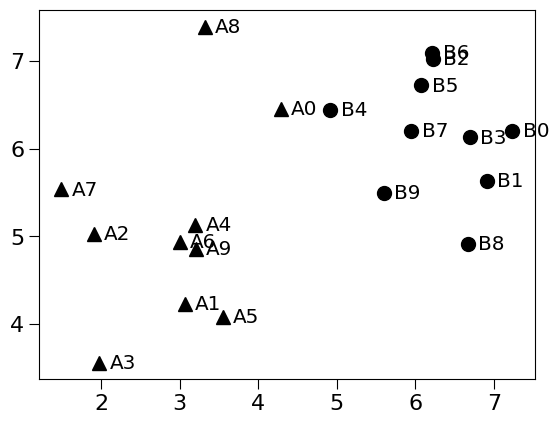

In [14]:
random.seed(1)
contrived_test(1, 2, True)

최종 결과
 클러스터의 센트로이드:[2.74674403 4.97411447], 클러스터에 속한 샘플:
A1, A2, A3, A4, A5, A6, A7, A8, A9
 클러스터의 센트로이드:[6.0698851  6.20948902], 클러스터에 속한 샘플:
A0, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9


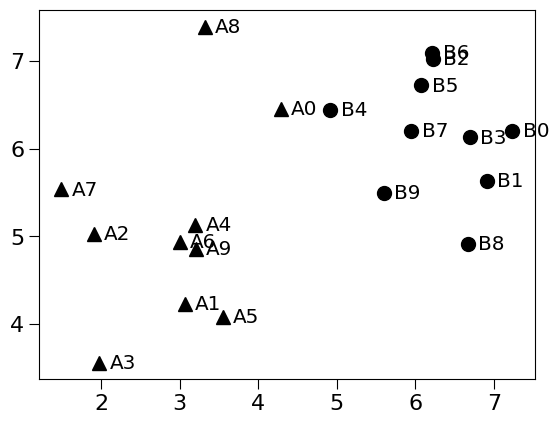

In [15]:
random.seed(1)
contrived_test(50, 2, False)

예제 25-7 세 개 에 분포에서 데이터 포인트 생성하기

In [16]:
def contrived_test2(num_trials, k, verbose = False): 
    x_mean = 3 
    x_sd = 1 
    y_mean = 5 
    y_sd = 1 
    n = 8 
    d1_samples = gen_distribution(x_mean,x_sd, y_mean, y_sd, n, 'A') 
    plot_samples(d1_samples, 'k^') 
    d2_samples = gen_distribution(x_mean+3,x_sd,y_mean, y_sd, n, 'B') 
    plot_samples(d2_samples, 'ko') 
    d3Samples = gen_distribution(x_mean, x_sd, y_mean+3, y_sd, n, 'C') 
    plot_samples(d3Samples, 'kx') 
    clusters = try_k_means(d1_samples + d2_samples + d3Samples, 
                           k, num_trials, verbose) 
    plt.ylim(0, 12) 
    print('최종 결과의 이질성:', 
          round(dissimilarity(clusters), 3)) 
    for c in clusters: 
        print('', c) 

최종 결과의 이질성: 90.128
 클러스터의 센트로이드:[5.5884966  4.43260236], 클러스터에 속한 샘플:
A0, A3, A5, B0, B1, B2, B3, B4, B5, B6, B7
 클러스터의 센트로이드:[2.80949911 7.11735738], 클러스터에 속한 샘플:
A1, A2, A4, A6, A7, C0, C1, C2, C3, C4, C5, C6, C7


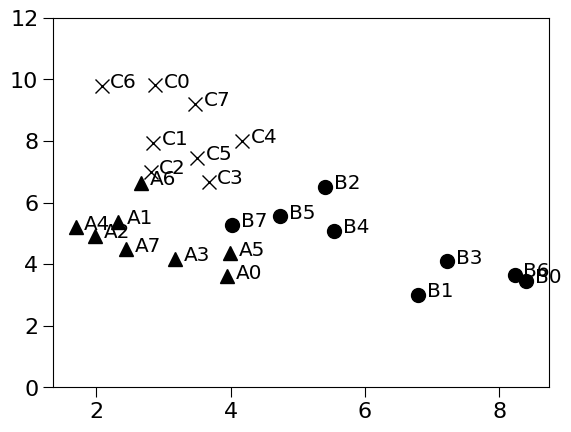

In [17]:
random.seed(0)
contrived_test2(40, 2)

최종 결과의 이질성: 42.757
 클러스터의 센트로이드:[7.66239972 3.55222681], 클러스터에 속한 샘플:
B0, B1, B3, B6
 클러스터의 센트로이드:[3.56907939 4.95707576], 클러스터에 속한 샘플:
A0, A1, A2, A3, A4, A5, A7, B2, B4, B5, B7
 클러스터의 센트로이드:[3.12083099 8.06083681], 클러스터에 속한 샘플:
A6, C0, C1, C2, C3, C4, C5, C6, C7


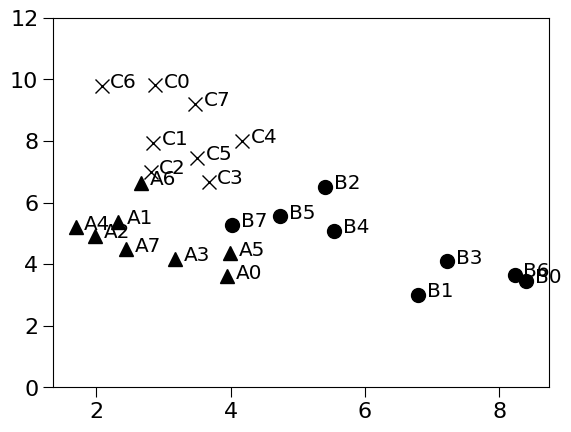

In [18]:
random.seed(0)
contrived_test2(40, 3)

최종 결과의 이질성: 11.441
 클러스터의 센트로이드:[2.10900238 4.99452866], 클러스터에 속한 샘플:
A1, A2, A4, A7
 클러스터의 센트로이드:[4.92742554 5.60609442], 클러스터에 속한 샘플:
B2, B4, B5, B7
 클러스터의 센트로이드:[2.80974427 9.60386549], 클러스터에 속한 샘플:
C0, C6, C7
 클러스터의 센트로이드:[3.27637435 7.28932247], 클러스터에 속한 샘플:
A6, C1, C2, C3, C4, C5
 클러스터의 센트로이드:[3.70472053 4.04178035], 클러스터에 속한 샘플:
A0, A3, A5
 클러스터의 센트로이드:[7.66239972 3.55222681], 클러스터에 속한 샘플:
B0, B1, B3, B6


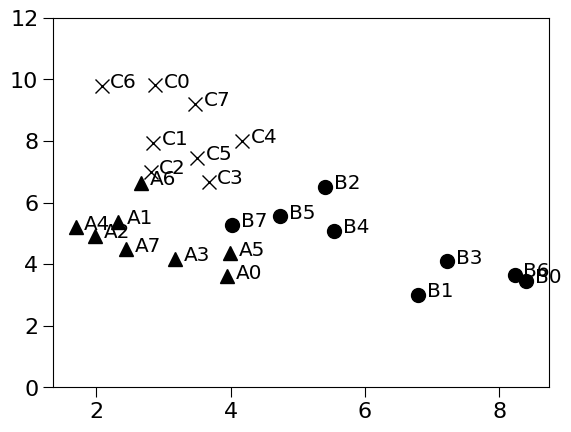

In [19]:
random.seed(0)
contrived_test2(40, 6)

## 25.4 실전 예제

예제 25-9 CSV 파일을 읽고 처리하기

In [20]:
import pandas as pd

def read_mammal_data(fName, scale_method = None): 
    """fName은 포유류의 치아 정보를 담은 CSV 파일입니다.
       종과 특성 벡터를 매핑한 딕셔너리를 반환합니다.
    """ 
    df = pd.read_csv('dentalFormulas.csv', comment = '#') 
    df = df.set_index('Name') 
    if scale_method != None: 
        for c in df.columns: 
            df[c] = scale_method(df[c]) 
    feature_vector_list = [np.array(df.loc[i].values) 
                           for i in df.index] 
    species_names = list(df.index) 
    return {species_names[i]: feature_vector_list[i] 
            for i in range(len(species_names))} 

def build_mammal_examples(species_dict): 
    examples = [] 
    for i in species_dict: 
        example = Example(i, species_dict[i]) 
        examples.append(example) 
    return examples 

def test_teeth(file_name, num_clusters, num_trials, 
               scale_method = None): 
    def print_clustering(clustering): 
        for c in clustering: 
            names = '' 
            for p in c.members(): 
                names += p.get_name() + ', ' 
            print('\n' + names[:-2]) #마지막 쉼표과 공백을 삭제합니다
    species_dict = read_mammal_data(file_name, scale_method) 
    examples = build_mammal_examples(species_dict) 
    print_clustering(try_k_means(examples, num_clusters, num_trials)) 

In [21]:
random.seed(0)
test_teeth('dentalFormulas.csv', 3, 40)


곰, 소, 사슴, 엘크, 물개, 회색물범, 사자, 바다사자

오소리, 퓨마, 개, 여우, 기니피그, 사람, 재규어, 캥커루, 밍크, 두더지, 생쥐, 돼지, 호저, 토끼, 너구리, 쥐, 붉은나무박쥐, 스컹크, 다람쥐, 늑대, 그라운드호그

무스


예제 25-10 스케일링 함수 

In [22]:
def z_scale(vals): 
    """vals은 실수 시퀀스라고 가정합니다""" 
    result = np.array(vals) - np.array(vals).mean() 
    return (result/np.std(result)).round(4) 

def linear_scale(vals): 
    """vals은 실수 시퀀스라고 가정합니다"""
    vals = np.array(vals) 
    vals -= vals.min() 
    return (vals/vals.max()).round(4) 

In [23]:
random.seed(0)
test_teeth('dentalFormulas.txt', 3, 40, z_scale)


오소리, 곰, 퓨마, 개, 여우, 물개, 회색물범, 사람, 재규어, 사자, 밍크, 두더지, 돼지, 너구리, 붉은나무박쥐, 바다사자, 스컹크, 늑대

기니피그, 캥커루, 생쥐, 호저, 토끼, 쥐, 다람쥐, 그라운드호그

소, 사슴, 엘크, 무스


예제 25-12 군집 결과에 레이블 부여하기

In [24]:
def add_labels(examples, label_file): 
    df = pd.read_csv(label_file, comment = '#') 
    df = df.set_index('Name') 
    for e in examples: 
        if e.get_name() in df.index: 
            e.set_label(df.loc[e.get_name()]['Diet']) 

def check_diet(cluster): 
    herbivores, carnivores, omnivores = 0, 0, 0 
    for m in cluster.members(): 
        if m.get_label() == 0: 
            herbivores += 1 
        elif m.get_label() == 1: 
            carnivores += 1 
        else: 
            omnivores += 1 
    print(' ', herbivores, '초식 동물,', carnivores, '육식 동물,', 
          omnivores, '잡식 동물\n') 

def test_teeth_diet(features_file, labels_file, num_clusters, 
                    num_trials, scale_method = None): 
    def print_clustering(clustering): 
        for c in clustering: 
            names = '' 
            for p in c.members(): 
                names += p.get_name() + ', ' 
            print(names[:-2]) 
            check_diet(c) 
    species_dict = read_mammal_data(features_file, scale_method) 
    examples = build_mammal_examples(species_dict) 
    add_labels(examples, labels_file) 
    print_clustering(try_k_means(examples, num_clusters, num_trials)) 

In [25]:
random.seed(0)
test_teeth_diet('dentalFormulas.csv', 'diet.csv', 3, 40, z_scale)

오소리, 곰, 퓨마, 개, 여우, 물개, 회색물범, 사람, 재규어, 사자, 밍크, 두더지, 돼지, 너구리, 붉은나무박쥐, 바다사자, 스컹크, 늑대
  0 초식 동물, 13 육식 동물, 5 잡식 동물

기니피그, 캥커루, 생쥐, 호저, 토끼, 쥐, 다람쥐, 그라운드호그
  3 초식 동물, 0 육식 동물, 5 잡식 동물

소, 사슴, 엘크, 무스
  4 초식 동물, 0 육식 동물, 0 잡식 동물

